# CARGA DE LIBRERÍAS

In [2]:
# Pandas y Numpy serán esenciales en mi análisis para manejar los datos y para tener herramientas matemáticas avanzadas para mi análsiis
import pandas as pd
import numpy as np
# Seaborn y matplotlib lo podré usar para poder hacer unas buenas visualizaciones para comunicar al departamento donde trabajo de la meor manera lso resultadps con gráficos estadísticos
import seaborn as sns
import matplotlib.pyplot as plt

# Sklearn me ayduará a escalar los datos y transdormarlos correctamente para una segmentación de los clientes más efectiva y agruparlos adecuadamente
from sklearn.preprocessing import PowerTransformer, StandardScaler, LabelEncoder
from sklearn.cluster import KMeans

from scipy.stats import boxcox, probplot, norm, shapiro

import os
import warnings
warnings.filterwarnings('ignore')
# Voy a mimprimir las versiones de las librerías:
## por si surge algún problema inesperado para identificar con mayor facilidad este problema
## para que las personas que ejecuten esto en la empresa donde trabajo después sepan las versiones exactas
print("Versiones de librerías:")
print(f"pandas: {pd.__version__}")
print(f"numpy: {np.__version__}")
print(f"seaborn: {sns.__version__}")

Versiones de librerías:
pandas: 2.2.2
numpy: 1.26.4
seaborn: 0.13.2


## Definición de funciones

In [4]:
def comprueba_normalidad(df, return_type='axes', title='Comprobación de normalidad'):
    '''
    Esta función genera automáticamente un dataframe el shapiro test de las variables numéricas
     así como las gráficas referentes a la QQ-plot de cada variable
    '''
    fig_tot = (len(df.columns))
    fig_por_fila = 3
    tamanio_fig  = 4
    num_filas = int( np.ceil(fig_tot/fig_por_fila) )    
    plt.figure( figsize=( fig_por_fila*tamanio_fig+5, num_filas*tamanio_fig+2 ) )
    c = 0 
    shapiro_test = {}
    lambdas = {}
    for i, col in enumerate(df.columns):
        ax = plt.subplot(num_filas, fig_por_fila, i+1)
        probplot(x = df[df.columns[i]], dist=norm, plot=ax)
        plt.title(df.columns[i])
        shapiro_test[df.columns[i]] = shapiro(df[df.columns[i]])
    plt.suptitle(title)
    plt.show()
    shapiro_test = pd.DataFrame(shapiro_test, index=['Test Statistic', 'p-value']).transpose()
    return shapiro_test

def plot_dispersion(x, figure_name, max_k = 25):
    inertia = []

    for k in range(2, max_k):
        kmeans = KMeans(n_clusters = k, n_init=10).fit(x)
        inertia.append(kmeans.inertia_) 

    plt.plot(range(2, max_k), inertia, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Dispersión')
    plt.title(figure_name)

# 1. EDA

## 1.1 Lectura de los datos
* Cargamos los datos del csv 'CLIENTES_RETAIL' con la ruta de este para, posteriormente, leer y visualizar las primeras filas y columnas del archivo con la información que tenemos para ver en base a qué información vamos a poder agrupar a nuestros clientes
* Imprimo las primeras columnas para visualizar qué tipo de datos tengo en cada una y ver las relaciones de cada una

In [7]:
CLIENTS_RETAIL = "C:/Users/67755488/Documents/SEGMENTACIÓN, CLUSTERING/PEC SEGMENTACIÓN/CLIENTS_RETAIL.csv"

df = pd.read_csv(CLIENTS_RETAIL, sep=';')

print("Datos de nuestros clientes:")
print("====================================================================================")

display(df.head())

print(df.shape)

Datos de nuestros clientes:


,id_cliente,edad,sexo,localizacion,num_compras_realizadas,ticket_total,cat_mas_comprada,ticket_promedio,metodo_pago,canal_uso,descuento_promedio,num_devoluciones,frecuencia_compra,diversidad_categorias,tiempo_cliente,rango_edad,num_campanas,total_productos,mes_frecuente
0,C000001,24.0,Femenino,Madrid,12,543.252183,Deportes,45.27,Tarjeta,Online,3.998426,0.0,4.40,6,12,14-25,4.0,44,Noviembre
1,C000002,37.0,Femenino,Castilla y León,4,1183.331133,Ocio,295.83,Tarjeta,Tienda Física,8.715349,0.0,2.80,7,6,36-50,4.0,58,Julio
2,C000003,32.0,Femenino,Cataluña,16,1096.816423,Hogar,68.55,Efectivo,Tienda Física,13.207076,0.0,11.37,7,0,26-35,3.0,29,Marzo
3,C000004,28.0,Femenino,Valencia,19,1151.071601,Hogar,60.58,Tarjeta,Online,8.885741,0.0,2.33,2,9,26-35,0.0,98,Noviembre
4,C000005,25.0,Masculino,Madrid,11,240.049975,Alimentación,21.82,Efectivo,Online,1.823647,0.0,10.43,6,6,14-25,1.0,123,Agosto


(25000, 19)


In [8]:
# muestro qué tipo de información tiene cada columna
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id_cliente              24378 non-null  object 
 1   edad                    24378 non-null  float64
 2   sexo                    25000 non-null  object 
 3   localizacion            25000 non-null  object 
 4   num_compras_realizadas  25000 non-null  int64  
 5   ticket_total            25000 non-null  float64
 6   cat_mas_comprada        25000 non-null  object 
 7   ticket_promedio         25000 non-null  float64
 8   metodo_pago             25000 non-null  object 
 9   canal_uso               25000 non-null  object 
 10  descuento_promedio      25000 non-null  float64
 11  num_devoluciones        24377 non-null  float64
 12  frecuencia_compra       25000 non-null  float64
 13  diversidad_categorias   25000 non-null  int64  
 14  tiempo_cliente          25000 non-null

## 1.2 Reviso los nulos que tiene este dataset

In [10]:
# 2
df.isnull().sum()

id_cliente                622
edad                      622
sexo                        0
localizacion                0
num_compras_realizadas      0
ticket_total                0
cat_mas_comprada            0
ticket_promedio             0
metodo_pago                 0
canal_uso                   0
descuento_promedio          0
num_devoluciones          623
frecuencia_compra           0
diversidad_categorias       0
tiempo_cliente              0
rango_edad                  0
num_campanas              623
total_productos             0
mes_frecuente               0
dtype: int64

##### Quitando las columnas categóricas, que no se muestran  en las estadísticas, vamos a extraer las siguientes conclusiones de lo que se muestra:
* podemos ver que el total de nulos en cada columna. En número de devoluciones y campañas en las puede significar que no han participado en ninguno de ellos.
* eliminaré la columna ID CLIENTE ya que es una información que no tiene datos del comportamiento de los clientes, es irrelevante y podría disporsionar los resultados  en el clustering.
* la columna de EDAD tiene valores nulos, por lo que la eliminaremos y trabajaré con los RANGOS DE EDAD.
* el TICKET TOTAL, al tener información sobre TICKET PROMEDIO, es una variable que no es importante, por lo que la eliminaremos más adelante.
* eliminaré más adelante también la columna DIVERSIDAD CATEGORIAS, ya que me interesa saber mejor cuáles la categoría exacta que compra más. El número de las diversas categorías que compra no me da información ya que no sé ni cuáles son. Por ejemplo, no sirve de mucho unir a clientes en un mismo grupo solo por comprar 5 categorías si esas categorías son diferentes, en cambio si uno los que compran una misma exacta me servirá para saber más sobre sus gustos y preferencias de esa categoría en concreto.
* esto hará que necesiote cambiar el formato de los datos de la columna categorica CATEGORÍA MÁS COMPRADA a datos numéricos.
* DEVOLUCIONES Y TOTAL PRODUCTO: voy a  crear una columna nueva derivada de estas dos variables ya que el total de productos comprados por el cliente debería ser el resultado de restar las devoluciones que ha hecho también.
* eliminaré la columna de DESCUENTOS ya que el ticket promedio ya cuenta con la información que se han gastado los clientes en general con Descuentos aplicados. Como no voy a realizar ninguna segmentación ni ningún Estduio basado en este dato en específico, no lo considero importante.
* reyenaré los datos nulos con '0' en la columna NÚMERO DE CAMPAÑAS de , ya que significa que no han hecho participado e ninguna de nuestras campañas y esto es una información muy potente para campañas de fidelización.
* codificaré las columnas MES FRECUENTE, METODO DE PAGO, SEXO, LOCALIZACIÓN y CANAL DE USO como numérico para identificar patrones estacionales para lanzar campañas dependiendo de nuestra segmentación de clientes, de lo que compren exacmente durante estos meses etc.
* Rango de edad: había dado por sentado que esta columna era numérica, pero al tener un guión el programa lo lee como una columna categórica. También tendré que transformarla.
* Para seguir con este EDA voy a mostrar las estadísticas a continuación:

In [12]:
df.describe()

,edad,num_compras_realizadas,ticket_total,ticket_promedio,descuento_promedio,num_devoluciones,frecuencia_compra,diversidad_categorias,tiempo_cliente,num_campanas,total_productos
count,24378.000000,25000.000000,25000.000000,25000.000000,25000.000000,24377.000000,25000.000000,25000.000000,25000.00000,24377.000000,25000.000000
mean,38.489458,17.969000,1174.393542,125.043354,10.074630,2.098084,6.206226,4.504680,9.86884,2.505435,100.528040
std,17.954229,20.679991,1482.571622,190.875642,9.120145,4.914816,3.317779,2.300859,7.02523,1.707139,57.897922
min,14.000000,1.000000,1.262549,0.020000,0.000164,0.000000,0.500000,1.000000,0.00000,0.000000,1.000000
25%,26.000000,6.000000,417.332482,32.987500,4.282602,0.000000,3.330000,2.000000,4.00000,1.000000,50.000000
50%,34.000000,12.000000,833.865377,69.085000,8.466861,0.000000,6.185000,5.000000,9.00000,3.000000,100.000000
75%,43.000000,18.000000,1245.303801,130.002500,12.584456,0.000000,9.070000,7.000000,15.00000,4.000000,151.000000
max,95.000000,100.000000,8496.834625,1499.470000,49.994490,20.000000,12.000000,8.000000,25.00000,5.000000,200.000000


In [13]:
# Lo voy a mostrar en un MAPA DE CALOR
df.describe().style.background_gradient(cmap ="coolwarm")

,edad,num_compras_realizadas,ticket_total,ticket_promedio,descuento_promedio,num_devoluciones,frecuencia_compra,diversidad_categorias,tiempo_cliente,num_campanas,total_productos
count,24378.000000,25000.000000,25000.000000,25000.000000,25000.000000,24377.000000,25000.000000,25000.000000,25000.000000,24377.000000,25000.000000
mean,38.489458,17.969000,1174.393542,125.043354,10.074630,2.098084,6.206226,4.504680,9.868840,2.505435,100.528040
std,17.954229,20.679991,1482.571622,190.875642,9.120145,4.914816,3.317779,2.300859,7.025230,1.707139,57.897922
min,14.000000,1.000000,1.262549,0.020000,0.000164,0.000000,0.500000,1.000000,0.000000,0.000000,1.000000
25%,26.000000,6.000000,417.332482,32.987500,4.282602,0.000000,3.330000,2.000000,4.000000,1.000000,50.000000
50%,34.000000,12.000000,833.865377,69.085000,8.466861,0.000000,6.185000,5.000000,9.000000,3.000000,100.000000
75%,43.000000,18.000000,1245.303801,130.002500,12.584456,0.000000,9.070000,7.000000,15.000000,4.000000,151.000000
max,95.000000,100.000000,8496.834625,1499.470000,49.994490,20.000000,12.000000,8.000000,25.000000,5.000000,200.000000


De estas visualizaciones podemos extraer las siguientes conclusiones:
* Al tratarse de una empresa minorista y además vender de forma online, tiene unos clientes con edades muy diversas, aunque existen más clientes que se encuentran en el tercer percentil.
* Los que más dinero se gastan en nuestra empresa son los más mayores, si atendemos a los datos de ticket promedio, ticket total y compras realizadas.
* Además, el número de campañas en las que participan las personas más jóvenes es notablemente inferior que en el de los más mayores, un dato que si, atendemos al avance de las tecnologías que tenemos hoy en día para llegar al público joven, es una oportunidad. Podemos llegar a ellos si mejoramos nuestras campañas. Esto nos servirá para fidelizar a estos nuevos clientes que es lo que nos interesa.

##### Por otra parte, como en el caso de las columnas categóricas no se muestra información, voy a mostrar la frecuencia de algunos datos que me interesan y considero importnte de estas:

In [16]:
# Categoría más comprada: me interesa saber cuales son los productos que más se venden en la empresa
df.cat_mas_comprada.value_counts()

cat_mas_comprada
Electrónica     3243
Tecnología      3186
Belleza         3123
Ocio            3121
Deportes        3111
Moda            3094
Hogar           3088
Alimentación    3034
Name: count, dtype: int64

In [17]:
# Localización: también quiero saber de dónde son la mayoría de mis clientes o en qué comunidades tenemos mñas clientes para futuras campañas y por si en el futuro queremos abrir otros centros y seguir creciendo 
df.localizacion.value_counts()

localizacion
Andalucía             4024
Madrid                3796
Cataluña              3479
Valencia              1961
Baleares              1279
Canarias              1270
Galicia               1251
País Vasco            1072
Asturias              1026
Extremadura            764
Castilla y León        746
Aragón                 737
Castilla-La Mancha     720
Navarra                499
Cantabria              499
La Rioja               484
Melilla                484
Murcia                 469
Ceuta                  440
Name: count, dtype: int64

In [18]:
# Canal de uso: me gustaría saber también la distribución de los datos en lo que se refiere a esta cuestión, muy relevante ya que nos muestra informción muy valiosa de en tanto a nuestros canales de distribución para posibles campañas futuras también y analizarlo en relación a nuestra competencia
df.canal_uso.value_counts()

canal_uso
Online           12501
Tienda Física    12499
Name: count, dtype: int64

A continuación, voy a realizar una visualización de violín  para mostrar la distribución de algunos datos de columnas que he seleccionado para ver asimetrías, valores extremos y cuartiles.

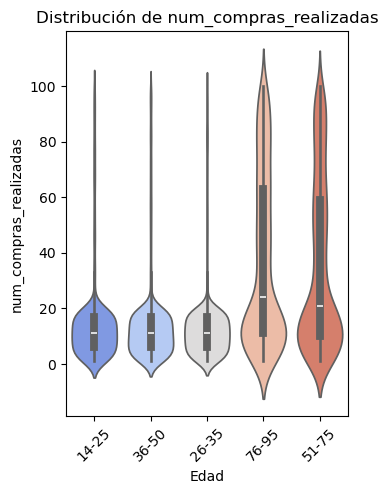

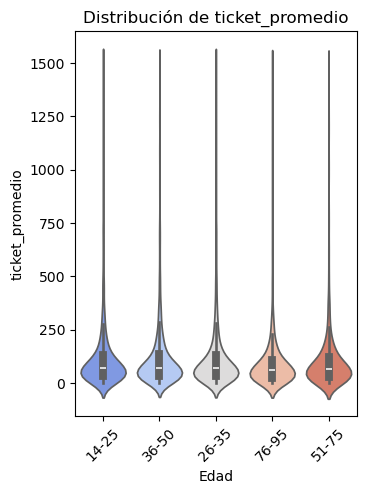

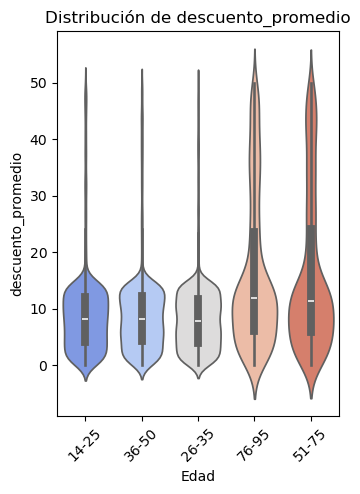

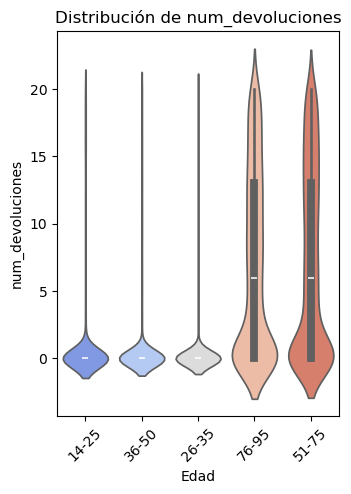

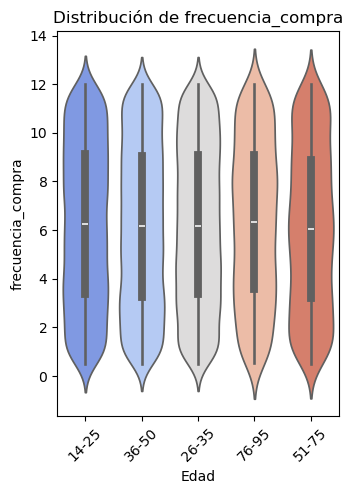

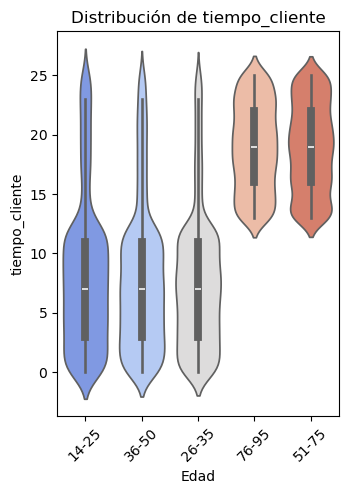

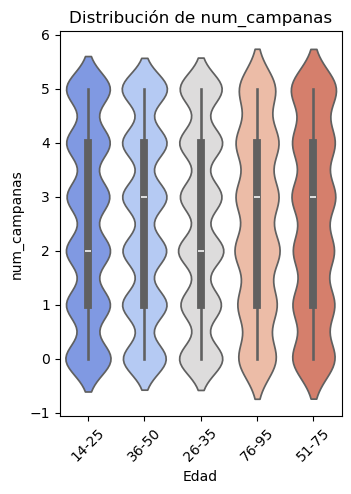

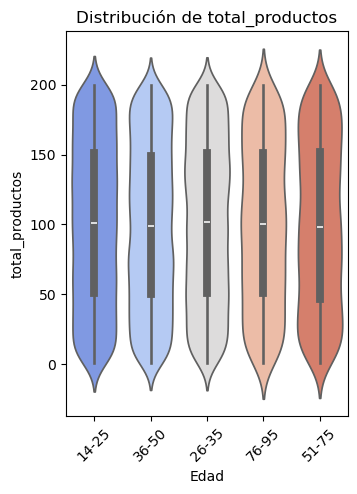

In [20]:
if 'rango_edad' in df.columns:
    eje_x = 'rango_edad'
else:
    eje_x = df.index  # Si no hay edad, usa el índice
    df[eje_x] = df.index  # Crear una columna con el índice (por si es necesario)

columnas_numericas = ['num_compras_realizadas', 'ticket_promedio', 'descuento_promedio', 'num_devoluciones', 'frecuencia_compra', 'tiempo_cliente',	'num_campanas',	'total_productos' ]

for columna in columnas_numericas:
    plt.figure(figsize=(8,5))  

    # Gráfico de violín
    plt.subplot(1,2,1)  # Primera subgráfica (1 fila, 2 columnas, 1er gráfico)
    sns.violinplot(x=df[eje_x], y=df[columna], palette="coolwarm")
    plt.xticks(rotation=45)  # Rotar etiquetas si hay muchas categorías
    plt.xlabel("Edad" if eje_x == "rango_edad" else "Índice")
    plt.ylabel(columna)
    plt.title(f"Distribución de {columna}")
    

### Conclusiones
#### Las zonas más gruesas de los violines que se forman en cada uno de los rangos de edad muestras donde se concentran la matoría de los datos:
    *El último rango de edad no aparece en el gráfico ya que no será muy representativo, hay pocos clientes en este grupo. Más adelante haré esta comprobación.
    * En lo que se refiere al ticket promedio se puede decir que los datos están muy concentrados y que son muy parecidos en todos los rangos de edad.
    * En el número compras realizadas, por ejemplo, vemos como los datos se concentran más en los dos últimos rangos de edad. Mientras que también son los clientes de estos rangos de edad que más devoluciones hacen, aunque también es verdad que sus gráficos más alargados en devoluciones una mayor variabilidad en este campo: son muchos los que no devuelven nada, es donde más grueso se muestra el violín, pero también se muestran devouluciones en los siguientes datos, algo que no sucede con los más jóvenes.
    * Los clientes mayores tienen más dispersión en lo que se refiere a los descuentos de los que se benefician: algunos clientes reciben descuentos significativamente más grandes que en otros grupos. Los descuento de clientes más jóvenes tienen una distribución más compacta, la mayoría usa descuentos entre 1-15. Posiblemete los mayores se beneficien de más descuentos porque realizan más compras y quizá obtengan más descuenstos de estrategias de fidelización por ello. De hecho, no existen datos de clientes en los dos últimos rangos de edad que estén en nuestra empresa menos de 10 años.
    * En las gráficas de total de productos y fecuencia de compra podemos ver como los datos estas muy dispersos yq ue son muy parecidos en todos los rangos.
    * En lo que se refiere a la frecuencia de compra los datos son muy parecidos a la par que dispersos en todos los rangos de edad.
    

In [22]:
df['rango_edad'].value_counts()

rango_edad
36-50    7676
26-35    7264
14-25    5947
51-75    2277
76-95    1836
Name: count, dtype: int64

# 2.  PREPROCESAMIENTO DE DATOS

## 2.1 Eliminación de columnas

In [25]:
df = df.drop(['id_cliente', 'edad', 'ticket_total', 'diversidad_categorias', 'descuento_promedio'], axis = 1)

print(df.columns)


Index(['sexo', 'localizacion', 'num_compras_realizadas', 'cat_mas_comprada',
       'ticket_promedio', 'metodo_pago', 'canal_uso', 'num_devoluciones',
       'frecuencia_compra', 'tiempo_cliente', 'rango_edad', 'num_campanas',
       'total_productos', 'mes_frecuente'],
      dtype='object')


## 2.2 Creación de nueva columna con 'total_productos' y 'num_devoluciones'

In [27]:
# Creo la nueva columna restando a total_productos los num_devoluciones
df['total_productos_devoluciones'] = df['total_productos'] - df['num_devoluciones']

# Elimino 'num_devoluciones' (no la consideraré importante si no adquiere su importancia con el total de productos ya que no voy a realizar ninguna segmentación teniendo cuenta este dato.. Conservaré num_productos porque me parece relevante.
df.drop(columns=['num_devoluciones'], inplace=True)

# Compruebo los nulos que tengo
print(df['total_productos_devoluciones'].isnull().sum())

623


podría a elminar las filas de clientes con nulos ya que no los consideraré clientes reales puesto que finalmente no han adquirido ningún producto al realizar las devoluciones, sino que son potenciales clientes. Sin embargo voy a reyenar con 0 estos nulos para que no me de problemas al final en KMeans cuando cargue de nuevo el archivo

In [29]:
# Elimino filas donde la columna total_productos_devoluciones tiene valores nulos
df['total_productos_devoluciones'] = df['total_productos_devoluciones'].fillna(0)

# Verifico nuevamente que no haya nulos en esa columna
print(df['total_productos_devoluciones'].isnull().sum())  # Debe mostrar 0



0


## 2.3 Transformaciónn de valores nulos a 0 de columna num_campanas

In [31]:
# Reemplazo los valores nulos por 0 en las columna específica
df['num_campanas'] = df['num_campanas'].fillna(0)

# Verificar si aún hay nulos en esas columnas
print(df['num_campanas'].isnull().sum())

0


In [32]:
columnas_numericas = df.select_dtypes(include=['int64', 'float64']).columns
print(columnas_numericas)

Index(['num_compras_realizadas', 'ticket_promedio', 'frecuencia_compra',
       'tiempo_cliente', 'num_campanas', 'total_productos',
       'total_productos_devoluciones'],
      dtype='object')


In [33]:
# verifico los cambios
display(df.head())

print(df.shape)

,sexo,localizacion,num_compras_realizadas,cat_mas_comprada,ticket_promedio,metodo_pago,canal_uso,frecuencia_compra,tiempo_cliente,rango_edad,num_campanas,total_productos,mes_frecuente,total_productos_devoluciones
0,Femenino,Madrid,12,Deportes,45.27,Tarjeta,Online,4.40,12,14-25,4.0,44,Noviembre,44.0
1,Femenino,Castilla y León,4,Ocio,295.83,Tarjeta,Tienda Física,2.80,6,36-50,4.0,58,Julio,58.0
2,Femenino,Cataluña,16,Hogar,68.55,Efectivo,Tienda Física,11.37,0,26-35,3.0,29,Marzo,29.0
3,Femenino,Valencia,19,Hogar,60.58,Tarjeta,Online,2.33,9,26-35,0.0,98,Noviembre,98.0
4,Masculino,Madrid,11,Alimentación,21.82,Efectivo,Online,10.43,6,14-25,1.0,123,Agosto,123.0


(25000, 14)


Tras estos cambios, voy a analizar las variables numéricas con las que me he quedado. Y para eso voy a analizar los outliers mostrando los boxplot de estas mismas columnas.

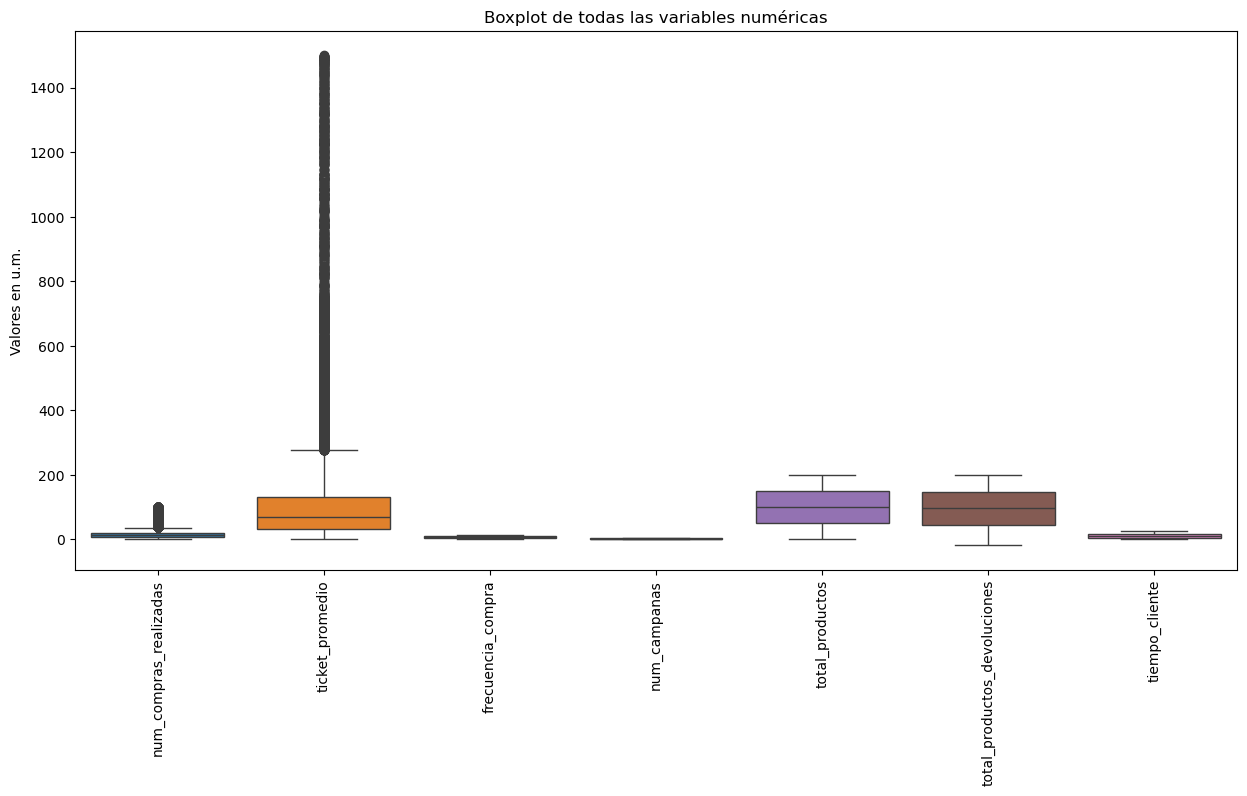

In [35]:
columnas_numericas= ['num_compras_realizadas', 'ticket_promedio', 'frecuencia_compra','num_campanas','total_productos','total_productos_devoluciones', 'tiempo_cliente']

plt.figure(figsize=(15,7))
ax = sns.boxplot(data=df[columnas_numericas])
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.title('Boxplot de todas las variables numéricas')
plt.ylabel('Valores en u.m.')
plt.show()

ahora, voy a mostrar la matriz de correlación para analizar problemas de multi-colinealidad.

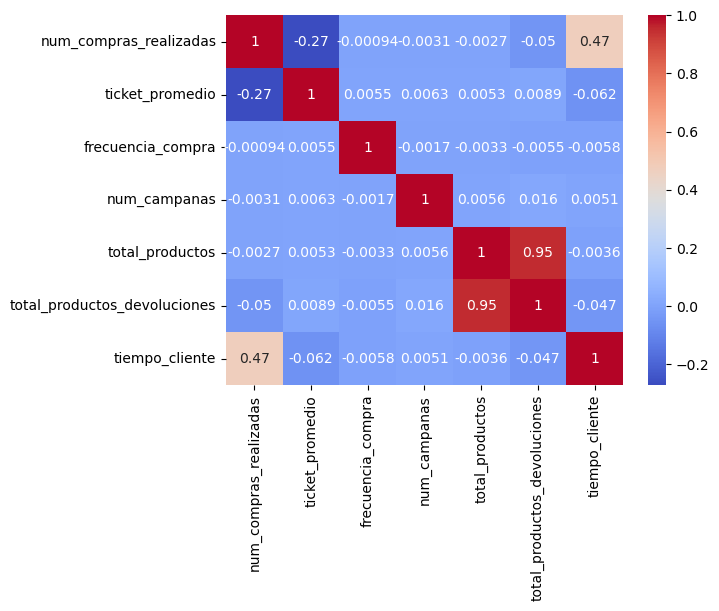

In [37]:
sns.heatmap(df[columnas_numericas].corr(), annot=True, cmap="coolwarm")
plt.show()

* num_compras_realizadas y ticket_promedio (-0.27)
Correlación negativa débil. Esto sugiere que los clientes con un ticket promedio alto tienden a hacer menos compras, lo que podría indicar que gastan más en cada compra en lugar de hacer muchas compras pequeñas.
* num_compras_realizadas y total_productos_devoluciones (-0.05)
Correlación casi nula. No parece haber una relación clara entre la cantidad de compras realizadas y el número total de productos devueltos.
* total_producto y ticket promedio (0,0053)
correlación muy débil. Esto quiere decir que los clientes que adquieren más productos, no necesariamente se gastan más dinero.
* num_compras_realizadas y tiempo_cliente (0.47)
Correlación positiva moderada. Indica que los clientes que han permanecido más tiempo suelen realizar más compras, lo que sugiere una posible lealtad o hábito de compra continuo.
* ticket_promedio y total_productos_devoluciones (0.0089)
Correlación prácticamente nula. El valor del ticket promedio no parece estar relacionado con la cantidad de productos devueltos.
* ticket_promedio y tiempo_cliente (-0.062)
Correlación muy baja y negativa. No hay una relación significativa entre el tiempo que un cliente lleva y el ticket promedio de sus compras.
* total_productos_devoluciones y tiempo_cliente (-0.047)
Correlación muy baja y negativa. El tiempo que un cliente ha permanecido no parece influir significativamente en la cantidad de productos que devuelve.

- Ajustes que realizaré:
	* total_productos_devoluciones: No tiene una correlación fuerte con ninguna otra variable, por lo que su relevancia en el análisis es baja. Evaluaré si mantenerla o eliminarla y en su lugar voy a seguir conservando total_producto ya que lo considero importante para el análisis.
	* ticket_promedio: Su correlación con otras variables es débil, pero sigue aportando información sobre los hábitos de compra.
	* tiempo_cliente: Tiene una correlación moderada con el número de compras realizadas, por lo que es una variable relevante a considerar.
    * frecuencia_compra : eliminaré esta columna ya que no existe ninguna correlación con cualquier otra, por lo que no es relevante
    * num_campanas: tiene una correlación muy baja con todas. La eliminaré porque no la considero importante.

* ELIMINACIÓN DE COLUMNAS 'FRECUENCIA_COMPRA', 'NUM_CAMPANAS' Y 'TOTAL_PRODUCTOS_DEVOLUCIONES'

In [40]:

df = df.drop(['frecuencia_compra', 'num_campanas', 'total_productos_devoluciones'], axis = 1)

print(df.shape)
print(df.columns)

(25000, 11)
Index(['sexo', 'localizacion', 'num_compras_realizadas', 'cat_mas_comprada',
       'ticket_promedio', 'metodo_pago', 'canal_uso', 'tiempo_cliente',
       'rango_edad', 'total_productos', 'mes_frecuente'],
      dtype='object')


In [41]:

# Convierto los int en float
df['num_compras_realizadas'] = pd.to_numeric(df['num_compras_realizadas'], errors="coerce")
df['tiempo_cliente'] = pd.to_numeric(df['tiempo_cliente'], errors="coerce")
df['total_productos'] = pd.to_numeric(df['total_productos'], errors="coerce")


A continuación, mostraré los histogramas de las columnas numéricas con las que me he quedado para visualizar la distribución de las mismas

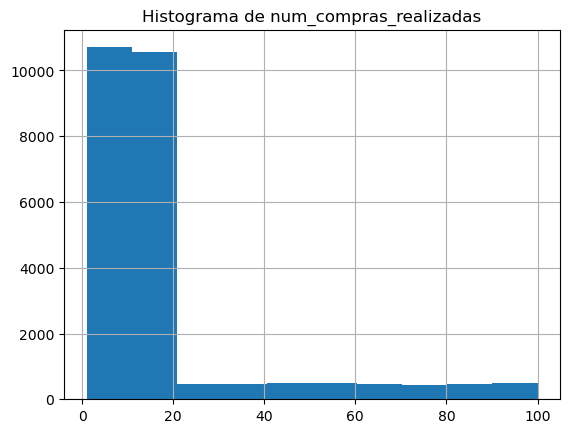

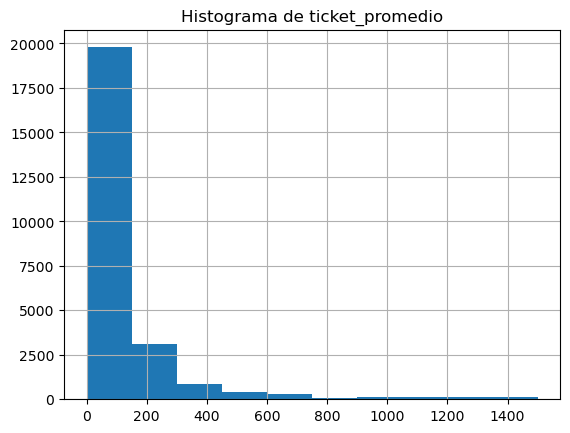

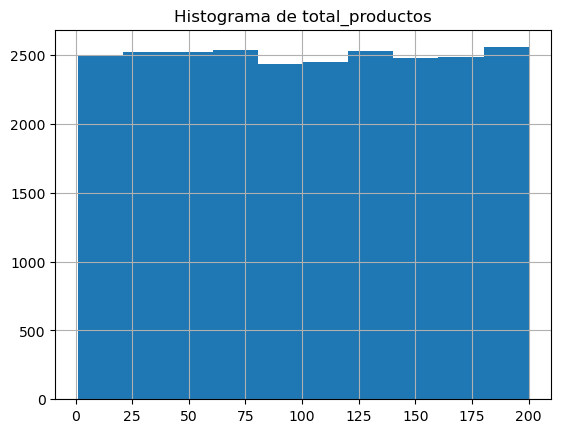

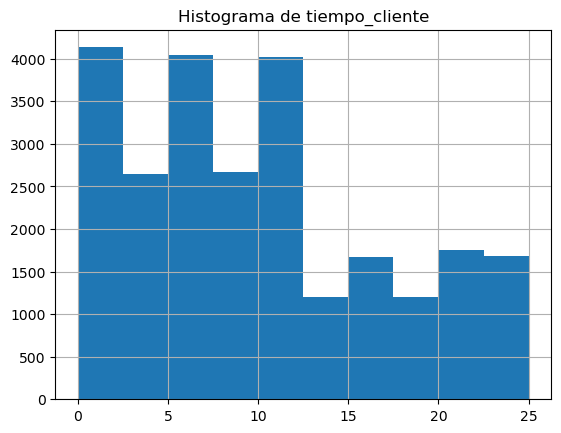

In [43]:
columnas_numericas = ['num_compras_realizadas', 'ticket_promedio','total_productos', 'tiempo_cliente']

for columna in columnas_numericas:
    plt.hist(df[columna])
    plt.title(str("Histograma de " + columna))
    plt.grid()
    plt.show()

Las variables no siguen una distribución normal, por lo que tendré que transformar las variables para que sigan una distribución normal y tratar los outliers.

### 2.2.2 Shapiro test

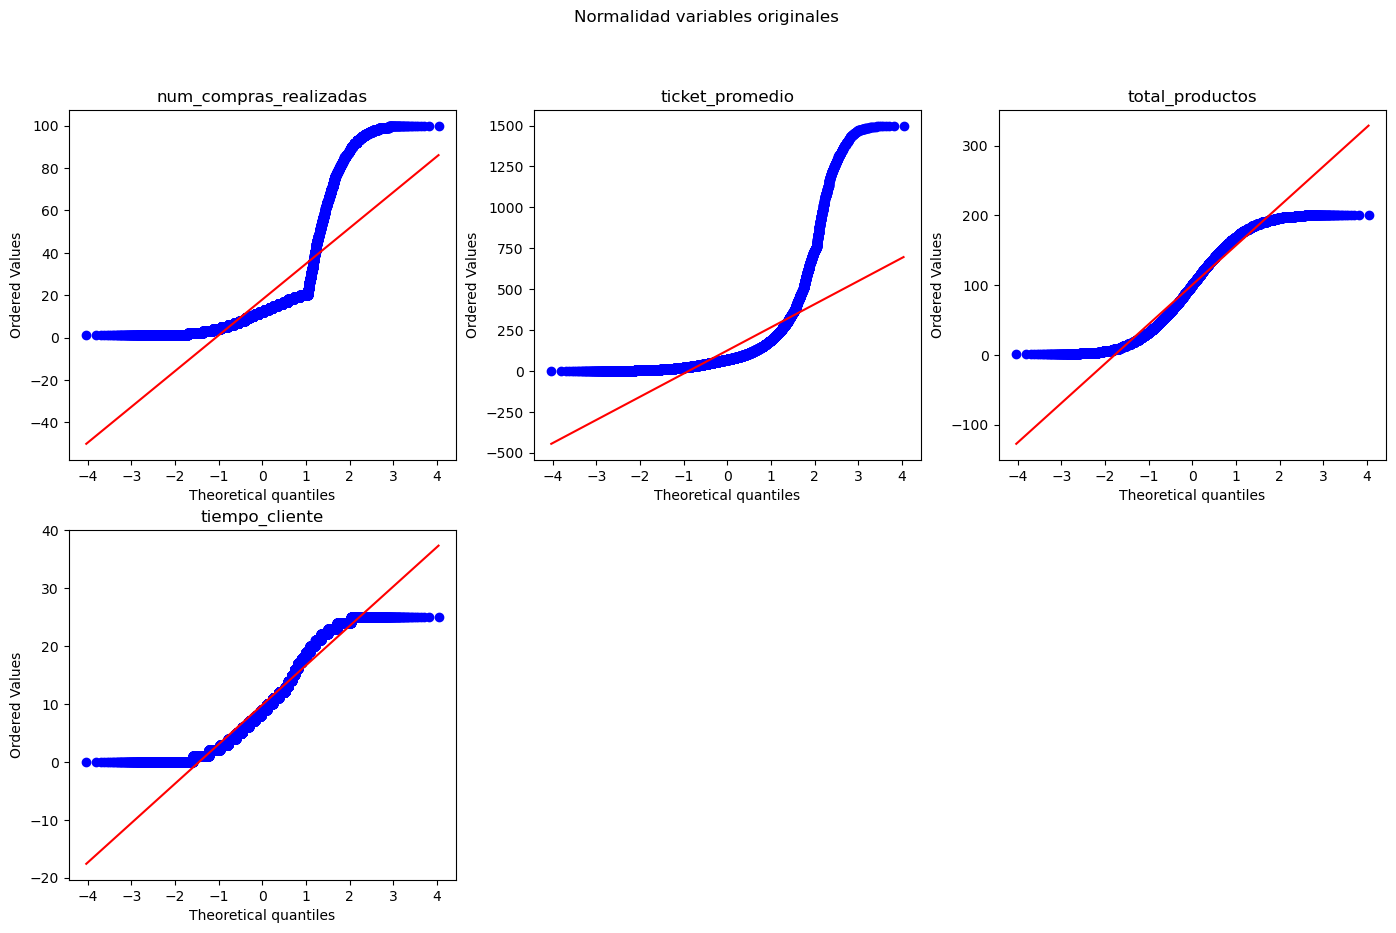

In [46]:
shapiro_test = comprueba_normalidad(df[columnas_numericas], title='Normalidad variables originales')

In [47]:
shapiro_test

,Test Statistic,p-value
num_compras_realizadas,0.667358,2.587370e-111
ticket_promedio,0.550281,1.678872e-119
total_productos,0.954250,8.345159e-65
tiempo_cliente,0.940348,2.760626e-70


El resultado del test shapiro que he realizado nos muestra una tabla con pvalues etremadamente bajos.
esto significa que los datos no provienen de una distribución normal.
En este caso, todas las variables tienen valores extremadamente bajos (< 0,05), por lo tanto, ninguna de estas variables sigue una distribución normal.


In [49]:
# Identifico las columnas numéricas continuas (que sean todas positivas, requisito de Box-Cox)
columnas_continuas = df.select_dtypes(include=["float"]).columns

# Verifico si hay valores <= 0 (Box-Cox solo funciona con valores positivos)
for col in columnas_continuas:
    if (df[col] <= 0).any():
        print(f" La columna '{col}' tiene valores <= 0. Se le sumará una constante para aplicar Box-Cox.")
        df[col] = df[col] + abs(df[col].min()) + 1  # Desplaza los valores a positivos

# Aplico transformación Box-Cox a cada columna continua
for col in columnas_continuas:
    df[col], _ = boxcox(df[col])



Ahora transformo las mismas variables en una transformación Box-Cox.

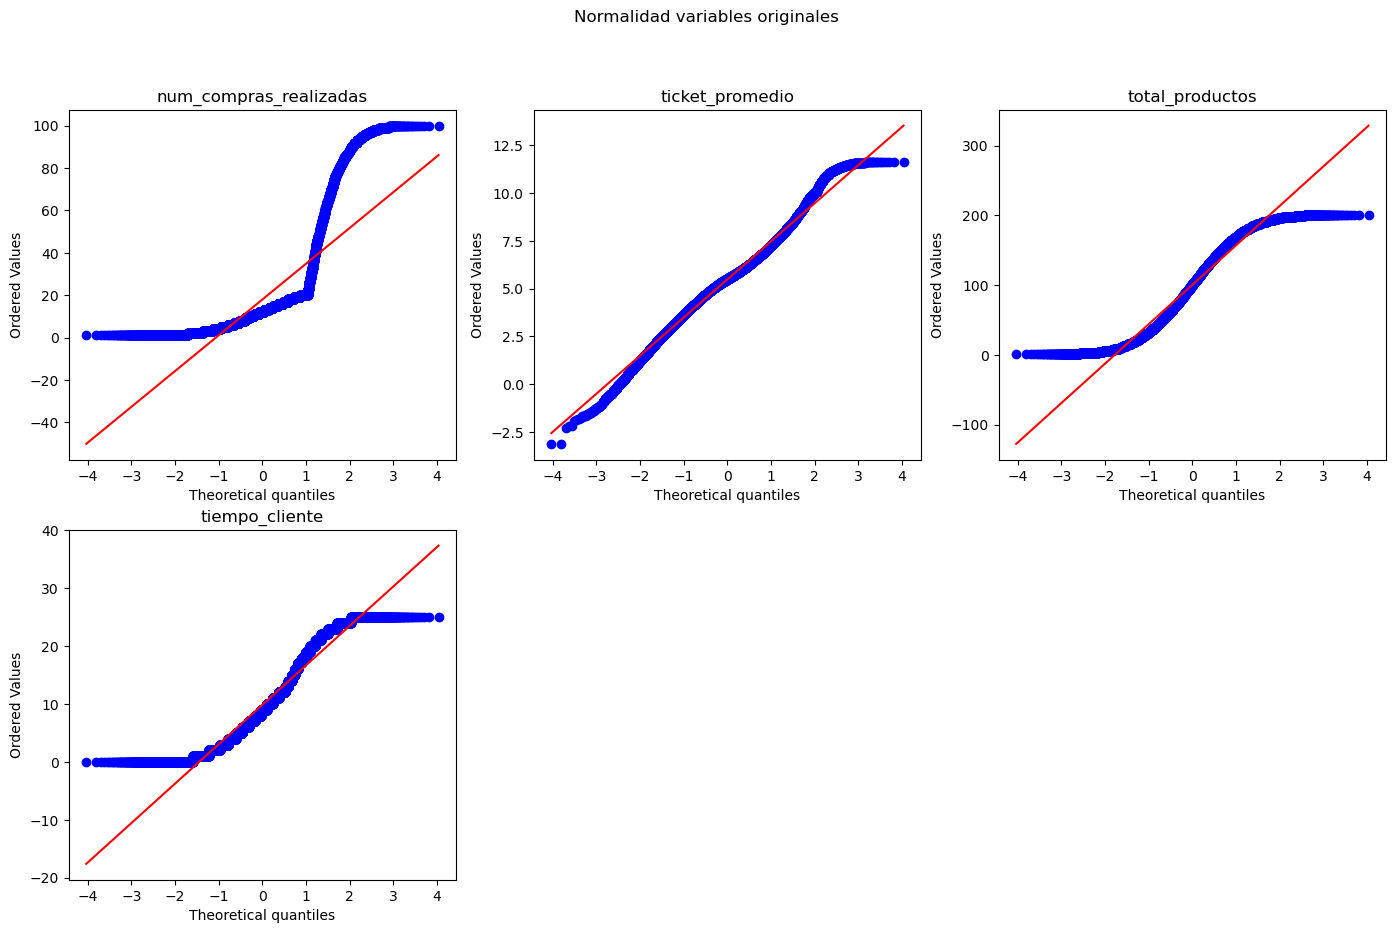

In [51]:
shapiro_test = comprueba_normalidad(df[columnas_numericas], title='Normalidad variables originales')

In [52]:
shapiro_test

,Test Statistic,p-value
num_compras_realizadas,0.667358,2.587370e-111
ticket_promedio,0.988049,1.422448e-40
total_productos,0.954250,8.345159e-65
tiempo_cliente,0.940348,2.760626e-70


Después de los cambios con Box-Cox, los resultados del test de Shapiro-Wilk siguen mostrando p-values extremadamente bajos para todas las variables, lo que significa que las distribuciones de los datos aún no son normales.

Comparando con la imagen anterior:
    * La variable ticket_promedio cambió su estadístico de prueba (Test Statistic) de 0.550281 a 0.988049, lo que indica que su distribución ahora es más cercana a la normal.
    * Sin embargo, su p-value sigue siendo muy bajo (1.42e-40), lo que significa que aún no se puede aceptar la hipótesis de normalidad.

A pesar de los cambios, aunque se han ido acercando, los datos siguen sin ajustarse a una distribución normal, por lo que si necesitaría utilizar otros métodos.

Tendréque revisar outliers.


In [54]:
# Shapiro

for columnas_numericas  in ['num_compras_realizadas', 'ticket_promedio','total_productos', 'tiempo_cliente']:
    # Aplico shapiro
    stat, p = shapiro(df[columnas_numericas])
    
    print('Valor de test=%.3f, p-value=%.3f' % (stat, p))
    # interpreto el resultado
    alpha = 0.05
    if p > alpha:
        print('La variable ',columnas_numericas, ' proviene de una distribución normal (no rechazamos H0) \n')
    else:
        print('La variable ',columnas_numericas, ' no proviene de una distribución normal (rechazamos H0), por lo tanto H1 \n')

Valor de test=0.667, p-value=0.000
La variable  num_compras_realizadas  no proviene de una distribución normal (rechazamos H0), por lo tanto H1 

Valor de test=0.988, p-value=0.000
La variable  ticket_promedio  no proviene de una distribución normal (rechazamos H0), por lo tanto H1 

Valor de test=0.954, p-value=0.000
La variable  total_productos  no proviene de una distribución normal (rechazamos H0), por lo tanto H1 

Valor de test=0.940, p-value=0.000
La variable  tiempo_cliente  no proviene de una distribución normal (rechazamos H0), por lo tanto H1 



### 2.2.3 Normalización del Dataset

Una vez realizados todos los cambios anteriores, ya puedo proceder a normalizar la variables numéricas con las que me he quedado. Lo haré a través de la librería sklearn StandardScaler (ya importado al principio del notbook):

In [57]:

scaler = StandardScaler()
num_cols = ['num_compras_realizadas', 'ticket_promedio','total_productos', 'tiempo_cliente']

df[num_cols] = scaler.fit_transform(df[num_cols])

In [58]:
# compruebo que se ha ejecutado correctamente
df.head()

,sexo,localizacion,num_compras_realizadas,cat_mas_comprada,ticket_promedio,metodo_pago,canal_uso,tiempo_cliente,rango_edad,total_productos,mes_frecuente
0,Femenino,Madrid,-0.288642,Deportes,-0.331008,Tarjeta,Online,0.303364,14-25,-0.976359,Noviembre
1,Femenino,Castilla y León,-0.675497,Ocio,1.312077,Tarjeta,Tienda Física,-0.550718,36-50,-0.734550,Julio
2,Femenino,Cataluña,-0.095215,Hogar,0.001387,Efectivo,Tienda Física,-1.404799,26-35,-1.235441,Marzo
3,Femenino,Valencia,0.049856,Hogar,-0.099343,Tarjeta,Online,-0.123677,26-35,-0.043665,Noviembre
4,Masculino,Madrid,-0.336999,Alimentación,-0.877453,Efectivo,Online,-0.550718,14-25,0.388138,Agosto


In [59]:
df.describe()

,num_compras_realizadas,ticket_promedio,tiempo_cliente,total_productos
count,2.500000e+04,2.500000e+04,2.500000e+04,2.500000e+04
mean,-9.094947e-17,-7.412382e-16,-4.547474e-17,-7.588596e-17
std,1.000020e+00,1.000020e+00,1.000020e+00,1.000020e+00
min,-8.205680e-01,-4.286176e+00,-1.404799e+00,-1.719060e+00
25%,-5.787836e-01,-5.738096e-01,-8.354115e-01,-8.727265e-01
50%,-2.886423e-01,7.772430e-03,-1.236767e-01,-9.120372e-03
75%,1.499064e-03,5.472288e-01,7.304050e-01,8.717579e-01
max,3.966764e+00,3.059237e+00,2.153874e+00,1.718092e+00


voy a hacer nuevamente las visualizaciones de los histogramas y bloxplot para ver los cambios tras la normalización

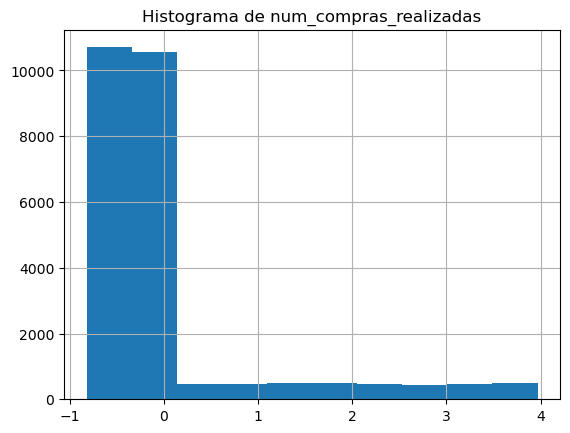

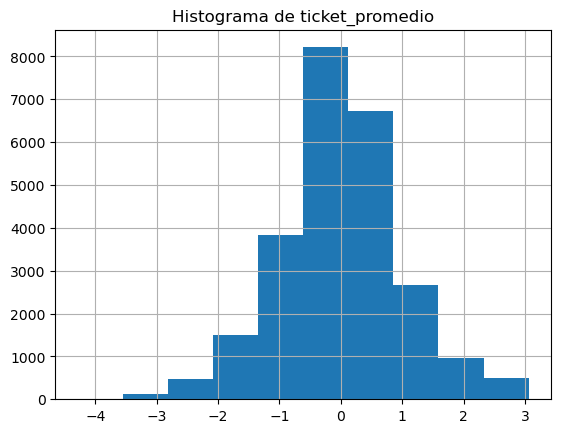

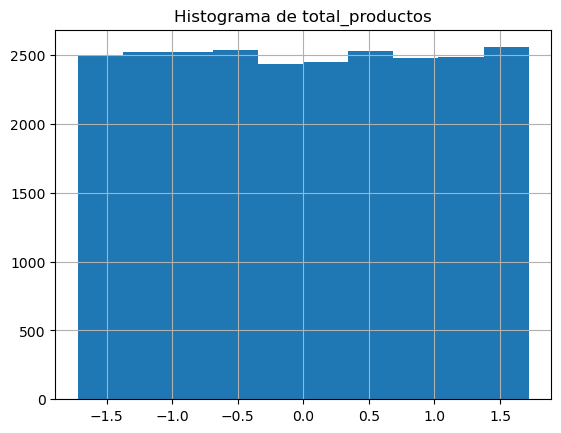

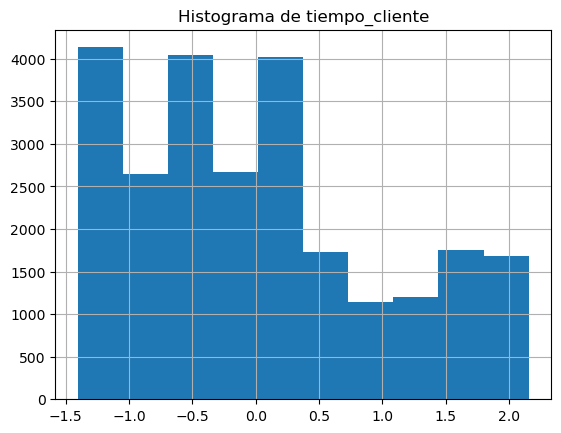

In [61]:
columnas_numericas = ['num_compras_realizadas', 'ticket_promedio','total_productos', 'tiempo_cliente']

for columna in columnas_numericas:
    plt.hist(df[columna])
    plt.title(str("Histograma de " + columna))
    plt.grid()
    plt.show()

Ahora al menos tengo una variable que se acerca a la forma gaussiana. Para tratar los outliers, volvemos a pintar todos los boxplots para analizar el efecto de los mismos en nuestras columnas.

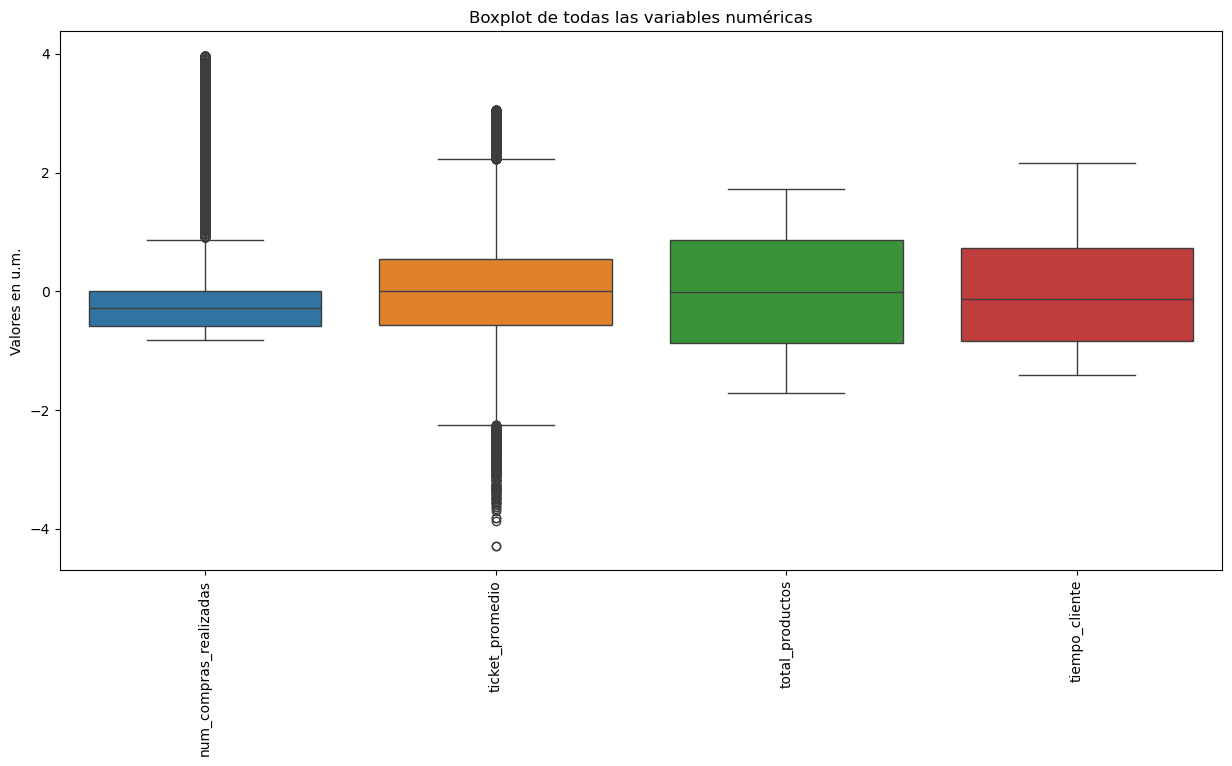

In [63]:
plt.figure(figsize=(15,7))
ax = sns.boxplot(data=df[columnas_numericas])
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.title('Boxplot de todas las variables numéricas')
plt.ylabel('Valores en u.m.')
plt.show()

In [64]:
# Shapiro

for columnas_numericas  in ['num_compras_realizadas', 'ticket_promedio','total_productos', 'tiempo_cliente']:
    # Aplico shapiro
    stat, p = shapiro(df[columnas_numericas])
    
    print('Valor de test=%.3f, p-value=%.3f' % (stat, p))
    # interpreto el resultado
    alpha = 0.05
    if p > alpha:
        print('La variable ',columnas_numericas, ' proviene de una distribución normal (no rechazamos H0) \n')
    else:
        print('La variable ',columnas_numericas, ' no proviene de una distribución normal (rechazamos H0), por lo tanto H1 \n')

Valor de test=0.667, p-value=0.000
La variable  num_compras_realizadas  no proviene de una distribución normal (rechazamos H0), por lo tanto H1 

Valor de test=0.988, p-value=0.000
La variable  ticket_promedio  no proviene de una distribución normal (rechazamos H0), por lo tanto H1 

Valor de test=0.954, p-value=0.000
La variable  total_productos  no proviene de una distribución normal (rechazamos H0), por lo tanto H1 

Valor de test=0.940, p-value=0.000
La variable  tiempo_cliente  no proviene de una distribución normal (rechazamos H0), por lo tanto H1 



Después de aplicar Box-Cox y StandardScaler los datos aún no siguen una distribución normal, por lo que lo más probable sea que la estructura de los datos simplemente no sea normalizable mediante transformaciones estándar.
Seguramente la distribución original es inherentemente no normal.
Algunas variables tienen distribuciones que no pueden volverse normales con transformaciones comunes porque los datos con sesgo extremo (muy asimétricos), como es el caso de num_compras_realizadas, o datos con múltiples picos (distribución multimodal),como por ejemplo tiempo_cliente.

Al tener valores atípicos muy grandes o muy pequeños, la transformación Box-Cox o la estandarización pueden no ser suficientes para normalizar la distribución de estas variables.


	
Ahora voy a trabajar los outliers empleando la técnica basada en el IQR para atenuarlos. De esta forma outliers se limitarán por los límites inferiores (Q1-1.5IQR) y superiores (Q3+1.5IQR)
* Voy a iterar sólo en columnas numéricas porque esta técnica no trabaja con booleanos

In [66]:
# defino el filtro solo columnas numéricas
columnas_numericas = df.select_dtypes(include=['int64', 'float64']).columns

for k in columnas_numericas:
    IQR = np.percentile(df[k], 75) - np.percentile(df[k], 25)
    
    limite_superior = np.percentile(df[k], 75) + 1.5 * IQR
    limite_inferior = np.percentile(df[k], 25) - 1.5 * IQR
    
    df[k] = np.where(df[k] > limite_superior, limite_superior, df[k])
    df[k] = np.where(df[k] < limite_inferior, limite_inferior, df[k])

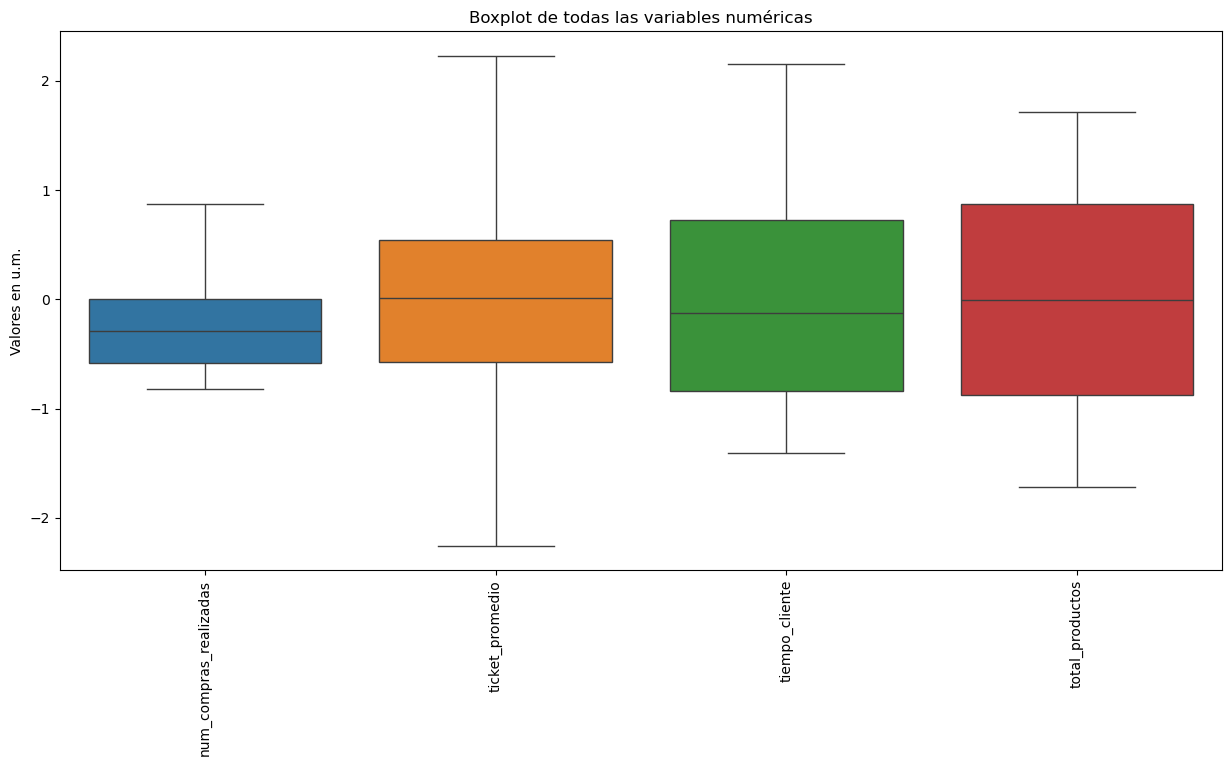

In [67]:
plt.figure(figsize=(15,7))
ax = sns.boxplot(data=df[columnas_numericas])
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.title('Boxplot de todas las variables numéricas')
plt.ylabel('Valores en u.m.')
plt.show()

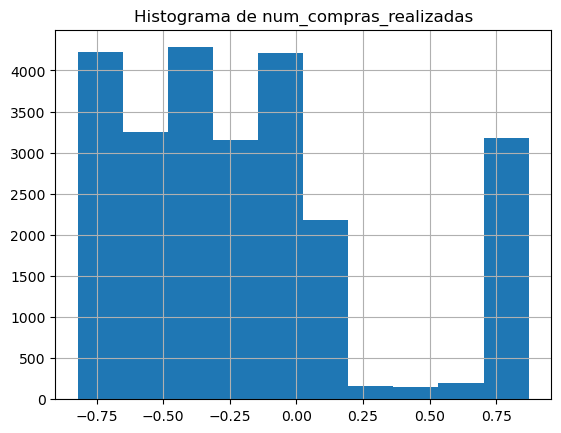

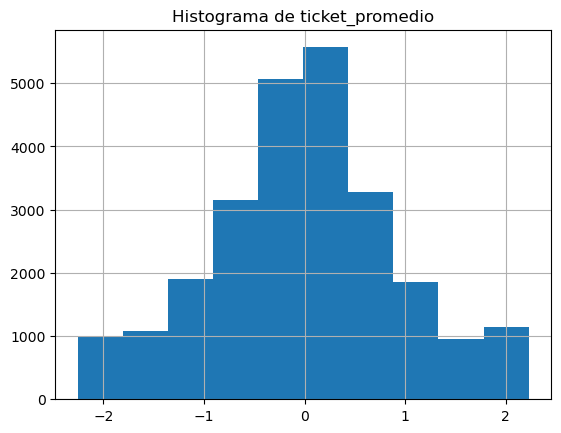

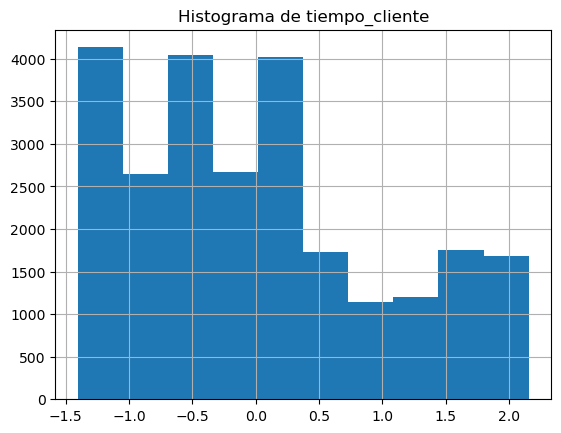

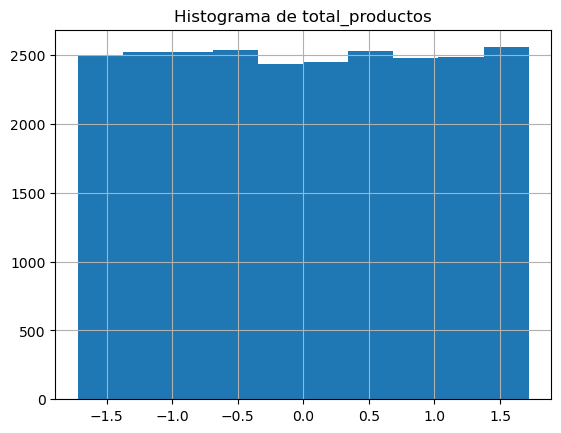

In [68]:
for columna in columnas_numericas:
    plt.hist(df[columna])
    plt.title(str("Histograma de " + columna))
    plt.grid()
    plt.show()

In [69]:
for columnas_numericas  in ['num_compras_realizadas', 'ticket_promedio','total_productos', 'tiempo_cliente']:
    # Aplico shapiro
    stat, p = shapiro(df[columnas_numericas])
    
    print('Valor de test=%.3f, p-value=%.3f' % (stat, p))
    # interpreto el resultado
    alpha = 0.05
    if p > alpha:
        print('La variable ',columnas_numericas, ' proviene de una distribución normal (no rechazamos H0) \n')
    else:
        print('La variable ',columnas_numericas, ' no proviene de una distribución normal (rechazamos H0), por lo tanto H1 \n')

Valor de test=0.874, p-value=0.000
La variable  num_compras_realizadas  no proviene de una distribución normal (rechazamos H0), por lo tanto H1 

Valor de test=0.988, p-value=0.000
La variable  ticket_promedio  no proviene de una distribución normal (rechazamos H0), por lo tanto H1 

Valor de test=0.954, p-value=0.000
La variable  total_productos  no proviene de una distribución normal (rechazamos H0), por lo tanto H1 

Valor de test=0.940, p-value=0.000
La variable  tiempo_cliente  no proviene de una distribución normal (rechazamos H0), por lo tanto H1 



Ahora, los datos siguen sin estar normalizados, pero se acercan más. num_compras realizadas casi roza los mismos valores que las otras variables.

In [71]:
display(df.head())

,sexo,localizacion,num_compras_realizadas,cat_mas_comprada,ticket_promedio,metodo_pago,canal_uso,tiempo_cliente,rango_edad,total_productos,mes_frecuente
0,Femenino,Madrid,-0.288642,Deportes,-0.331008,Tarjeta,Online,0.303364,14-25,-0.976359,Noviembre
1,Femenino,Castilla y León,-0.675497,Ocio,1.312077,Tarjeta,Tienda Física,-0.550718,36-50,-0.734550,Julio
2,Femenino,Cataluña,-0.095215,Hogar,0.001387,Efectivo,Tienda Física,-1.404799,26-35,-1.235441,Marzo
3,Femenino,Valencia,0.049856,Hogar,-0.099343,Tarjeta,Online,-0.123677,26-35,-0.043665,Noviembre
4,Masculino,Madrid,-0.336999,Alimentación,-0.877453,Efectivo,Online,-0.550718,14-25,0.388138,Agosto


* Tras haber trabajado con las columnas numéricas, ahora es momento de hacerlo con las categóricas. Voy a convertirlas en booleanos.

Para transformar las columnas categóricas  en formato numérico he elegido el método de crear dummies, esto es, con One-Hot Encoding. Al principio había pensado usar la herramienta de Label Encoding, pero esto me puede presentar problemas ya que no evita que se asigne de forma arbitraria números. Al usar dummies, Kmeans no interpretará estos números como si tuvieran un orden entre ellos.

In [74]:
# One-Hot Encoding para las columnas 'sexo','metodo_pago','canal_uso','mes_frecuente', 'localizacion', 'cat_mas_comprada'.
# anadiré drop_first = True para que elimine la primera categoría de cada columna para evitar dependencia lineal entre las nuevas columnas
df = pd.get_dummies(df, columns=['sexo','metodo_pago','canal_uso','mes_frecuente', 'localizacion', 'cat_mas_comprada', 'rango_edad' ], drop_first=True)

#compruebo que se han creado todas las columnas adicionales
display(df.head())
print(df.shape)

,num_compras_realizadas,ticket_promedio,tiempo_cliente,total_productos,sexo_Masculino,metodo_pago_Efectivo,metodo_pago_PayPal,metodo_pago_Tarjeta,canal_uso_Tienda Física,mes_frecuente_Agosto,...,cat_mas_comprada_Deportes,cat_mas_comprada_Electrónica,cat_mas_comprada_Hogar,cat_mas_comprada_Moda,cat_mas_comprada_Ocio,cat_mas_comprada_Tecnología,rango_edad_26-35,rango_edad_36-50,rango_edad_51-75,rango_edad_76-95
0,-0.288642,-0.331008,0.303364,-0.976359,False,False,False,True,False,False,...,True,False,False,False,False,False,False,False,False,False
1,-0.675497,1.312077,-0.550718,-0.734550,False,False,False,True,True,False,...,False,False,False,False,True,False,False,True,False,False
2,-0.095215,0.001387,-1.404799,-1.235441,False,True,False,False,True,False,...,False,False,True,False,False,False,True,False,False,False
3,0.049856,-0.099343,-0.123677,-0.043665,False,False,False,True,False,False,...,False,False,True,False,False,False,True,False,False,False
4,-0.336999,-0.877453,-0.550718,0.388138,True,True,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False


(25000, 49)


In [75]:
scaler = StandardScaler()
num_cols = ['num_compras_realizadas', 'ticket_promedio','total_productos', 'tiempo_cliente']

df[num_cols] = scaler.fit_transform(df[num_cols])
df.head()

,num_compras_realizadas,ticket_promedio,tiempo_cliente,total_productos,sexo_Masculino,metodo_pago_Efectivo,metodo_pago_PayPal,metodo_pago_Tarjeta,canal_uso_Tienda Física,mes_frecuente_Agosto,...,cat_mas_comprada_Deportes,cat_mas_comprada_Electrónica,cat_mas_comprada_Hogar,cat_mas_comprada_Moda,cat_mas_comprada_Ocio,cat_mas_comprada_Tecnología,rango_edad_26-35,rango_edad_36-50,rango_edad_51-75,rango_edad_76-95
0,-0.202806,-0.345467,0.303364,-0.976359,False,False,False,True,False,False,...,True,False,False,False,False,False,False,False,False,False
1,-0.988101,1.381003,-0.550718,-0.734550,False,False,False,True,True,False,...,False,False,False,False,True,False,False,True,False,False
2,0.189841,0.003798,-1.404799,-1.235441,False,True,False,False,True,False,...,False,False,True,False,False,False,True,False,False,False
3,0.484327,-0.102045,-0.123677,-0.043665,False,False,False,True,False,False,...,False,False,True,False,False,False,True,False,False,False
4,-0.300968,-0.919642,-0.550718,0.388138,True,True,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False


In [76]:
# compruebo que todos los cambios están bien
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 49 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   num_compras_realizadas           25000 non-null  float64
 1   ticket_promedio                  25000 non-null  float64
 2   tiempo_cliente                   25000 non-null  float64
 3   total_productos                  25000 non-null  float64
 4   sexo_Masculino                   25000 non-null  bool   
 5   metodo_pago_Efectivo             25000 non-null  bool   
 6   metodo_pago_PayPal               25000 non-null  bool   
 7   metodo_pago_Tarjeta              25000 non-null  bool   
 8   canal_uso_Tienda Física          25000 non-null  bool   
 9   mes_frecuente_Agosto             25000 non-null  bool   
 10  mes_frecuente_Diciembre          25000 non-null  bool   
 11  mes_frecuente_Enero              25000 non-null  bool   
 12  mes_frecuente_Febr

# 3. SEGMENTACIÓN DE CLIENTES UTILIZANDO KMEANS

Para empezar, voy a obtener el parámetro K, con el método del codo, para determinar el número óptimo de clusters, haciendo pruebas con 15K, 25K y 35K.

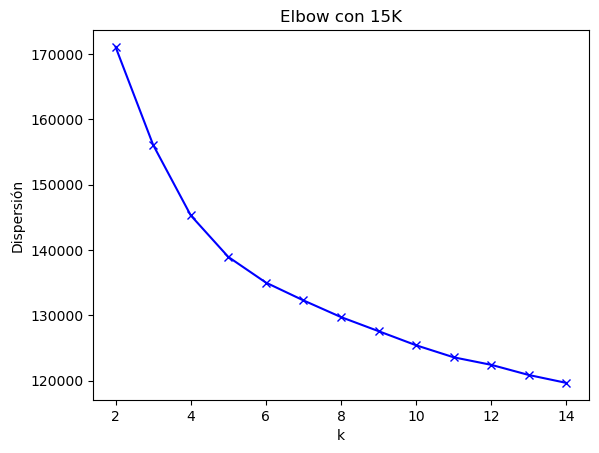

In [79]:
plot_dispersion(x=df, figure_name='Elbow con 15K',max_k=15)

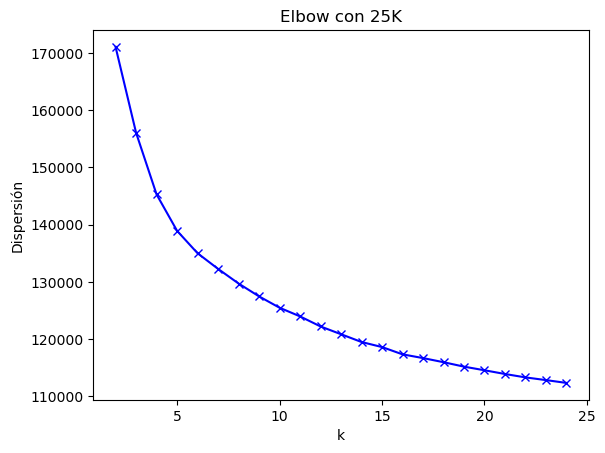

In [80]:
plot_dispersion(x=df, figure_name='Elbow con 25K',max_k=25)

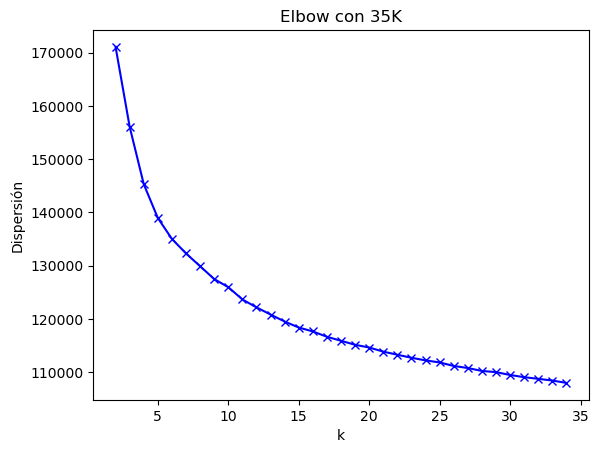

In [81]:
plot_dispersion(x=df, figure_name='Elbow con 35K',max_k=35)

Después de ejecutar este método, veo que la dispersión disminuye al principio, aunque la pendiente se suaviza. Creo que el cambio más notable ocurre en torno a K=5 o 10, por lo que elegiré 5.

In [83]:
segmentos_empresa  = KMeans(n_clusters=8, n_init="auto").fit(df)

In [84]:
segmentos_empresa .cluster_centers_

array([[-2.03029626e-01, -1.63522508e-01,  1.35355748e+00,
        -8.64935372e-01,  4.97724687e-01,  3.25938567e-01,
         8.30489192e-02,  4.83503982e-01,  4.99431172e-01,
         8.24800910e-02,  8.24800910e-02,  7.56541524e-02,
         8.64618885e-02,  8.36177474e-02,  8.02047782e-02,
         7.50853242e-02,  8.19112628e-02,  9.67007964e-02,
         9.21501706e-02,  7.84982935e-02,  2.95790671e-02,
         3.64050057e-02,  4.89192264e-02,  4.60750853e-02,
         1.99089875e-02,  2.78725825e-02,  2.73037543e-02,
         1.42775882e-01,  1.42207053e-02,  3.12855518e-02,
         5.06257110e-02,  2.33219568e-02,  1.52445961e-01,
         1.76336746e-02,  1.93401593e-02,  1.99089875e-02,
         4.20932878e-02,  7.33788396e-02,  1.31399317e-01,
         1.38794084e-01,  1.26848692e-01,  1.15472127e-01,
         1.21729238e-01,  1.25711035e-01,  1.26848692e-01,
         1.26848692e-01,  1.53014790e-01,  3.17406143e-01,
         2.42889647e-01],
       [-2.72785346e-02, -5.47

In [85]:
model = KMeans(n_clusters=8, n_init='auto')
model.fit(df)

KMeans()

Obtengo las predicciones

In [87]:
segmentos_empresa = segmentos_empresa .predict(df)

Ahora voy a cargar los datos originales de nuevo y, será en ese dataframe en el que asignaré el vector de segmentación

In [89]:
df_clustering = pd.read_csv("CLIENTS_RETAIL.csv", sep=";")

In [90]:
df_clustering["Segmentacion"] = segmentos_empresa 
df_clustering.head()

,id_cliente,edad,sexo,localizacion,num_compras_realizadas,ticket_total,cat_mas_comprada,ticket_promedio,metodo_pago,canal_uso,descuento_promedio,num_devoluciones,frecuencia_compra,diversidad_categorias,tiempo_cliente,rango_edad,num_campanas,total_productos,mes_frecuente,Segmentacion
0,C000001,24.0,Femenino,Madrid,12,543.252183,Deportes,45.27,Tarjeta,Online,3.998426,0.0,4.40,6,12,14-25,4.0,44,Noviembre,1
1,C000002,37.0,Femenino,Castilla y León,4,1183.331133,Ocio,295.83,Tarjeta,Tienda Física,8.715349,0.0,2.80,7,6,36-50,4.0,58,Julio,5
2,C000003,32.0,Femenino,Cataluña,16,1096.816423,Hogar,68.55,Efectivo,Tienda Física,13.207076,0.0,11.37,7,0,26-35,3.0,29,Marzo,1
3,C000004,28.0,Femenino,Valencia,19,1151.071601,Hogar,60.58,Tarjeta,Online,8.885741,0.0,2.33,2,9,26-35,0.0,98,Noviembre,1
4,C000005,25.0,Masculino,Madrid,11,240.049975,Alimentación,21.82,Efectivo,Online,1.823647,0.0,10.43,6,6,14-25,1.0,123,Agosto,7


## 3.1 Interpretación de segmentos

Primero vamos a ver cómo se han repartido nuetsros clientes en los diferentes segmentos

In [93]:
df_clustering.Segmentacion.value_counts()

Segmentacion
7    5576
1    5433
5    3510
2    3402
3    1800
6    1783
0    1758
4    1738
Name: count, dtype: int64

In [94]:
df_clustering.Segmentacion.value_counts(normalize=True)

Segmentacion
7    0.22304
1    0.21732
5    0.14040
2    0.13608
3    0.07200
6    0.07132
0    0.07032
4    0.06952
Name: proportion, dtype: float64

In [95]:
df_clustering["Segmentacion"] = segmentos_empresa
df_clustering.head()

,id_cliente,edad,sexo,localizacion,num_compras_realizadas,ticket_total,cat_mas_comprada,ticket_promedio,metodo_pago,canal_uso,descuento_promedio,num_devoluciones,frecuencia_compra,diversidad_categorias,tiempo_cliente,rango_edad,num_campanas,total_productos,mes_frecuente,Segmentacion
0,C000001,24.0,Femenino,Madrid,12,543.252183,Deportes,45.27,Tarjeta,Online,3.998426,0.0,4.40,6,12,14-25,4.0,44,Noviembre,1
1,C000002,37.0,Femenino,Castilla y León,4,1183.331133,Ocio,295.83,Tarjeta,Tienda Física,8.715349,0.0,2.80,7,6,36-50,4.0,58,Julio,5
2,C000003,32.0,Femenino,Cataluña,16,1096.816423,Hogar,68.55,Efectivo,Tienda Física,13.207076,0.0,11.37,7,0,26-35,3.0,29,Marzo,1
3,C000004,28.0,Femenino,Valencia,19,1151.071601,Hogar,60.58,Tarjeta,Online,8.885741,0.0,2.33,2,9,26-35,0.0,98,Noviembre,1
4,C000005,25.0,Masculino,Madrid,11,240.049975,Alimentación,21.82,Efectivo,Online,1.823647,0.0,10.43,6,6,14-25,1.0,123,Agosto,7


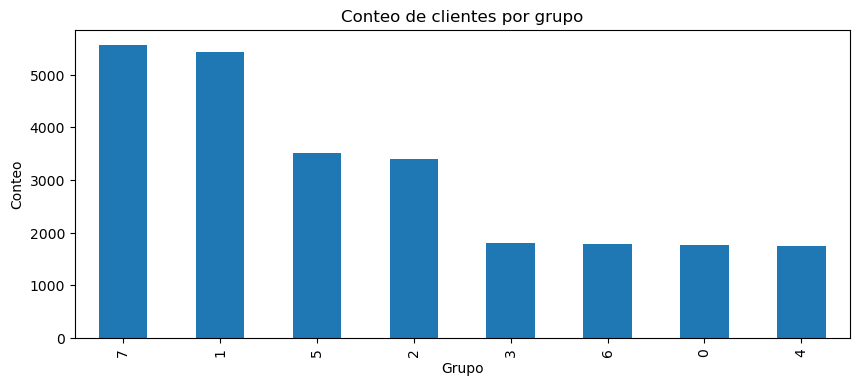

In [96]:
df_clustering.Segmentacion.value_counts().plot(kind='bar', figsize=(10,4))
plt.title('Conteo de clientes por grupo')
plt.xlabel('Grupo')
_ = plt.ylabel('Conteo')

¿cuáles serían esos clientes "perfectos" a través de los promedios? analizaré los centroides

In [98]:
df_clustering.describe()

,edad,num_compras_realizadas,ticket_total,ticket_promedio,descuento_promedio,num_devoluciones,frecuencia_compra,diversidad_categorias,tiempo_cliente,num_campanas,total_productos,Segmentacion
count,24378.000000,25000.000000,25000.000000,25000.000000,25000.000000,24377.000000,25000.000000,25000.000000,25000.00000,24377.000000,25000.000000,25000.000000
mean,38.489458,17.969000,1174.393542,125.043354,10.074630,2.098084,6.206226,4.504680,9.86884,2.505435,100.528040,3.674760
std,17.954229,20.679991,1482.571622,190.875642,9.120145,4.914816,3.317779,2.300859,7.02523,1.707139,57.897922,2.454551
min,14.000000,1.000000,1.262549,0.020000,0.000164,0.000000,0.500000,1.000000,0.00000,0.000000,1.000000,0.000000
25%,26.000000,6.000000,417.332482,32.987500,4.282602,0.000000,3.330000,2.000000,4.00000,1.000000,50.000000,1.000000
50%,34.000000,12.000000,833.865377,69.085000,8.466861,0.000000,6.185000,5.000000,9.00000,3.000000,100.000000,4.000000
75%,43.000000,18.000000,1245.303801,130.002500,12.584456,0.000000,9.070000,7.000000,15.00000,4.000000,151.000000,6.000000
max,95.000000,100.000000,8496.834625,1499.470000,49.994490,20.000000,12.000000,8.000000,25.00000,5.000000,200.000000,7.000000


In [99]:
print(df_clustering.columns)

Index(['id_cliente', 'edad', 'sexo', 'localizacion', 'num_compras_realizadas',
       'ticket_total', 'cat_mas_comprada', 'ticket_promedio', 'metodo_pago',
       'canal_uso', 'descuento_promedio', 'num_devoluciones',
       'frecuencia_compra', 'diversidad_categorias', 'tiempo_cliente',
       'rango_edad', 'num_campanas', 'total_productos', 'mes_frecuente',
       'Segmentacion'],
      dtype='object')


In [100]:
columnas_numericas = df_clustering[['num_compras_realizadas','ticket_promedio', 'metodo_pago', 'tiempo_cliente','total_productos','Segmentacion']].groupby(["Segmentacion"]).mean(numeric_only=True)
columnas_numericas.style.background_gradient(cmap="coolwarm")


,num_compras_realizadas,ticket_promedio,tiempo_cliente,total_productos
Segmentacion,,,,
0,11.997725,85.901035,19.377702,50.451081
1,13.789067,44.914585,5.978649,50.583103
2,5.029394,292.915647,6.179306,150.272781
3,62.170556,62.685406,19.035000,149.807222
4,10.775029,140.726559,19.376870,149.520138
5,5.068661,286.573826,6.552422,50.137607
6,62.305104,66.472855,18.887269,50.255749
7,13.736011,45.326065,6.193687,151.247131


Conclusiones de la Segmentación de Clientes
### Clientes habituales
* Cluster 4: clientes que fieles que relaizan muchas compras y también con una cantidad importante de productos. Su ticket promedio es moderado
* Cluster 5: clientes con ticket promedio muy alto. Aunque realizan pocas compras, tienen un número de productos importante también.
* Cluster 1: clientes con pocas compras pero ticket promedio alto. Son los que llevan más tiempo en la empresa.
### Clientes que adquieren muchos productos
* Clusters 7 y 2: con clientes nuevos, llevan muy poco en la empresa pero tienen un ticket promedio moderado.
### Clientes espontáneos
* Clusters 3, 6 y 0: clientes, por un lado, como en los segmentos 6 y 3, que no adquieren muchos productos y tienen un gasto moderado. Los del cluster 0 compran más cantidad pero se gastan menos, sin embargo los 3 coinciden más o menos en la cantidad de compras.


###  silhouette

In [103]:

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

columnas_numericas = ['num_compras_realizadas', 'ticket_promedio', 'total_productos', 'tiempo_cliente']
x = df_clustering[columnas_numericas]

# Escalo los datos
scaler = StandardScaler()
scaled = scaler.fit_transform(x)



# Calculo el Silhouette Score
silhouette_kmeans = silhouette_score(scaled, segmentos_empresa )

print(f"Silhouette Score para K-Means: {silhouette_kmeans}")



Silhouette Score para K-Means: 0.19692076759685828


El resultado la esta prueba me da un resultado no optimo aunque cambie los números de clusters entre 5 y 10 por lo que algo ha salido mal en el proceso.
Por ello voy a realizarlo con otro método.

## 3.2 PCA

In [106]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

In [107]:


# 1. Seleccionar solo las columnas numéricas para el PCA
columnas_numericas = ['num_compras_realizadas', 'ticket_promedio', 'total_productos', 'tiempo_cliente']
X = df[columnas_numericas]

# 2. Normalizo los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3. Aplico PCA para reducir dimensiones (pruebo con 3 componentes)
pca = PCA(n_components=3) 
X_pca = pca.fit_transform(X_scaled)

# 4. Ver la varianza explicada por cada componente
print("Varianza explicada por cada componente:", pca.explained_variance_ratio_)
print("Varianza total explicada:", sum(pca.explained_variance_ratio_))



Varianza explicada por cada componente: [0.41849148 0.25000483 0.2303594 ]
Varianza total explicada: 0.8988557089172302


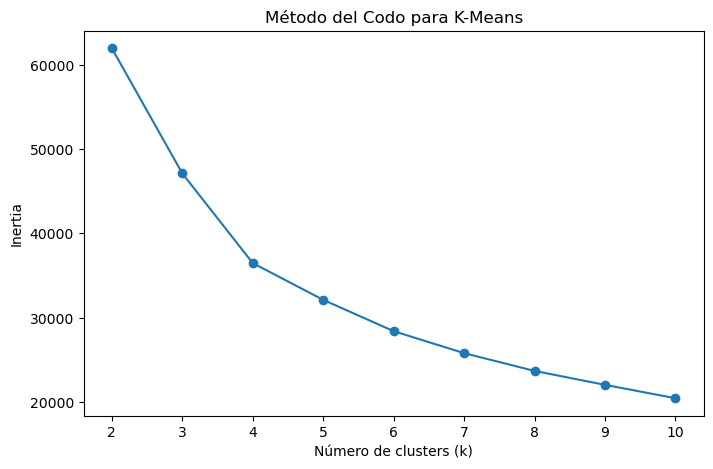

In [108]:
# 1 Pruebo diferentes valores de k con el método del codo
inertia = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_pca)
    inertia.append(kmeans.inertia_)

# 2. Voy a hacer una visualizació plot para ver a rasgos generales los datos
plt.figure(figsize=(8, 5))
plt.plot(K_range, inertia, marker='o', linestyle='-')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Inertia')
plt.title('Método del Codo para K-Means')
plt.show()



Silhouette Score para k=4: 0.3025


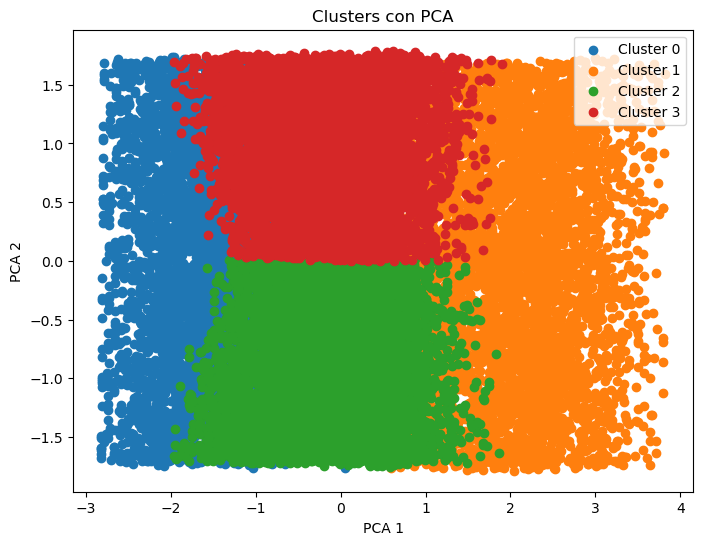

In [109]:
# 1. voy a elegir k=4 para probar
k_optimo = 4  
kmeans_final = KMeans(n_clusters=k_optimo, random_state=42, n_init=10)
df['Cluster'] = kmeans_final.fit_predict(X_pca)

# 9. Evaluo con Silhouette Score
silhouette_avg = silhouette_score(X_pca, df['Cluster'])
print(f"Silhouette Score para k={k_optimo}: {silhouette_avg:.4f}")

# 10. Graficar los clusters en el espacio reducido de PCA
plt.figure(figsize=(8, 6))
for cluster in range(k_optimo):
    plt.scatter(X_pca[df['Cluster'] == cluster, 0], 
                X_pca[df['Cluster'] == cluster, 1], 
                label=f'Cluster {cluster}')

plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('Clusters con PCA')
plt.legend()
plt.show()

el Silhouette Score me sale mejor aunque no es óptimo tampoco. Los diferentes colores representan los 4 clusters de clientes. 
los clusters se encuentran buen separados por lo que la segmentación es mejor quitando algunos puntos de clientes qeu se encuentran en dos clusters.

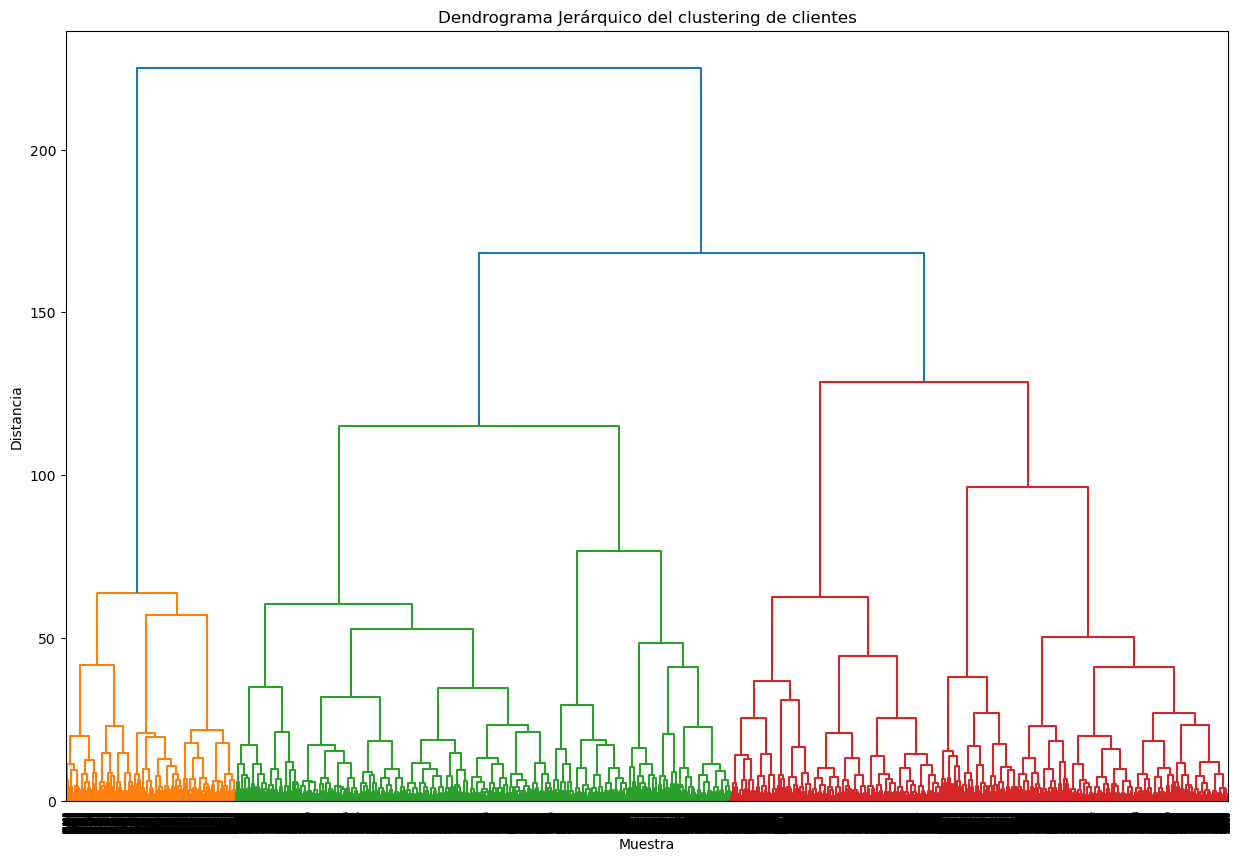

In [111]:
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt 

plt.figure(figsize=(15, 10))
dendrogram(linkage(X_scaled, method='ward'))
plt.title('Dendrograma Jerárquico del clustering de clientes')
plt.xlabel('Muestra')
plt.ylabel('Distancia')
plt.show()

* Ahora analizamos las variables categóricas:

In [113]:
df_clustering['sexo'] = df_clustering['sexo'].map(
    {1:'Hombre', 2:'Mujer'}
)

df_clustering['metodo_pago'] = df_clustering['metodo_pago'].map(
    {4:'Tarjeta', 3:'Efectivo', 2:'PayPal', 1:'Bizum'}
)
df_clustering['canal_uso'] = df_clustering['canal_uso'].map(
    {2:'Online', 1:'Tienda Física'}
)

df_clustering['cat_mas_comprada'] = df_clustering['cat_mas_comprada'].map(
    {8:'Deportes', 7:'Ocio', 6:'Hogar', 5:'Alimentación', 4:'Tecnología', 3:'Electrónica', 2:'Belleza', 1:'Moda'})
    
df_clustering['mes_frecuente'] = df_clustering['mes_frecuente'].map(
    {12:'Noviembre', 11: 'Julio', 10:'Marzo', 9:'Agosto', 8:'Octubre',
     7:'Abril', 6:'Enero', 5:'Mayo',4:'Diciembre',
     3:'Septiembre', 2:'Junio', 1:'Febrero'})
    
df_clustering['localizacion'] = df_clustering['localizacion'].map(
    {18:'Madrid', 17:'Castilla y León', 16:'Cataluña', 15:'Valencia', 14:'Aragón', 13:'La Rioja',
     12: 'País Vasco', 11:'Andalucía', 10:'Canarias', 9:'Baleares' 'Navarra',8:'Castilla-La Mancha', 7:'Galicia', 6:'Asturias', 5:'Extremadura', 4:'Ceuta', 3:'Melilla',
     2:'Murcia', 1:'Cantabria'})
    
df_clustering['rango_edad'] = df_clustering['rango_edad'].map(
    {5:'14-25', 4:'36-50', 3:'26-35', 2:'76-95', 1:'51-75'})



In [ ]:
for cluster in range(8):
    print("Estadísticas variables categóricas segmento ", cluster)
    filtro = df_clustering[df_clustering["cat_mas:comprada"] == cluster]
    
    print("\t-> Estadísticas del grupo ", cluster, "sobre sexo")
    print(filtro.sexo.value_counts())
    
    print("\t-> Estadísticas del grupo ", cluster, "sobre categoría más comprada")
    print(filtro.cat_mas_comprada.value_counts(), "\n")

* lo he intentado hasta el final pero no sé qué ha fallado

Para terminar, voy a mostrar las realaciones entre las variables a través de sus segmentos.

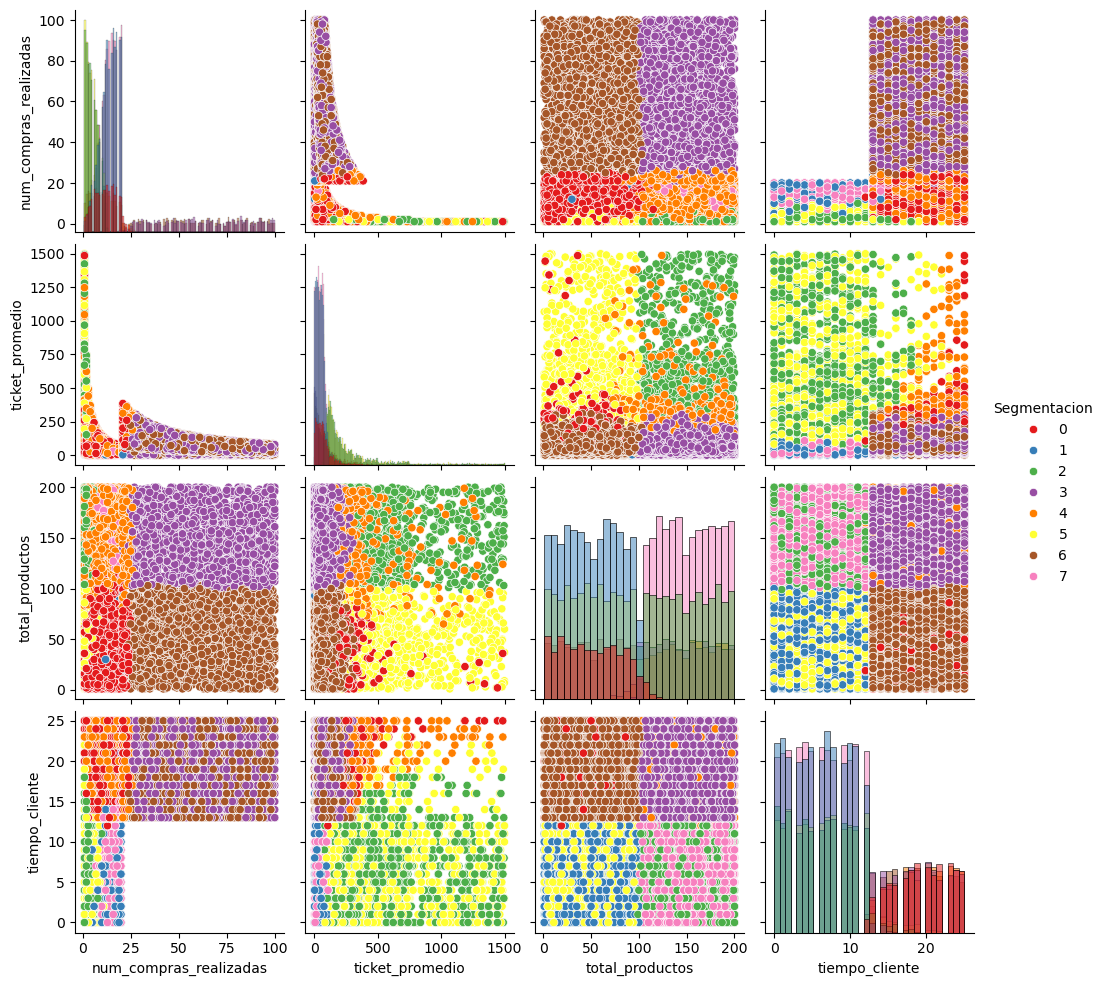

In [127]:
sns.pairplot(df_clustering,
             vars = columnas_numericas,
             diag_kind="hist",
             hue="Segmentacion", 
             palette = "Set1")
plt.show()